## Copy

In this task, a sequence of bit vectors is provided to the model. The input sequence starts with a reserved start vector, then some random binary bit vectors, followed by a reserved stop vector. The model is expected to start reproducing the exact input bit vectors immediately after observing the stop vector.

In [1]:
from util import *
from dnc_lstm import DNC
from dnc_ff import DNCFF
from autograd import grad
from autograd.misc.optimizers import rmsprop, adam

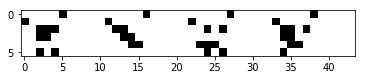

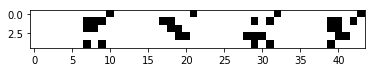

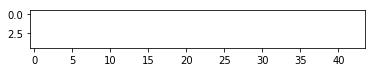

In [2]:
def seq(seq_len, seq_width):
    """
    Implements the copy task - section 4.1 from the NTM paper.
    Returns inputs, outputs, and a mask for loss calculation
    """
    rand_tile = np.random.randint(2, size=(seq_len, seq_width))
    inputs = np.zeros((seq_len*2+3, seq_width+2))
    inputs[0,1] = 1
    inputs[seq_len+1,0] = 1
    inputs[1:seq_len+1, 2:] = rand_tile
    targets = np.zeros((seq_len*2+3, seq_width+1))
    targets[-1,0] = 1
    targets[seq_len+2:-1, 1:] = rand_tile
    mask = np.zeros((seq_len*2+3, seq_width+1))
    mask[seq_len+2:,:] = 1
    return inputs, targets, mask

def long_copy(seq_len, seq_width, repeat=4):
    inputs, targets, masks = [], [], []
    for i in range(repeat):
        inpt, tar, mask = seq(seq_len, seq_width)
        inputs.append(inpt)
        targets.append(tar)
        masks.append(mask)
    inputs = np.vstack(inputs)
    targets = np.vstack(targets)
    masks = np.ones_like(targets) # np.vstack(masks)
    return inputs, targets, masks

# print seq(4, 4)
for item in long_copy(4,4):
    display(item.T)

Training DNC...
('Iteration', 0, 'Train loss:', 0.69503228167640196)
Test loss:  0.694567429618
Input


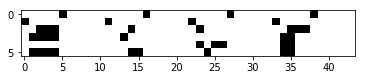

Target


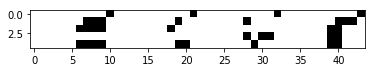

Predicted


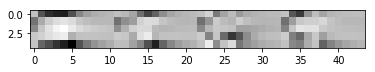

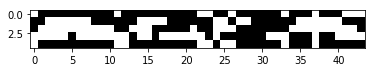

('Iteration', 1000, 'Train loss:', 0.20447556280155266)
Test loss:  0.200185461653
Input


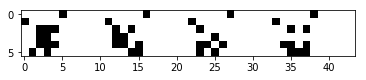

Target


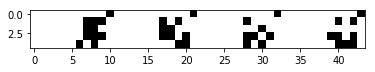

Predicted


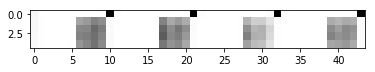

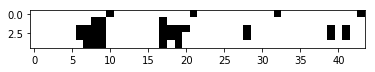

('Iteration', 2000, 'Train loss:', 0.18558648981293202)
Test loss:  0.190224545893
Input


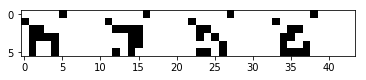

Target


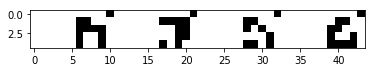

Predicted


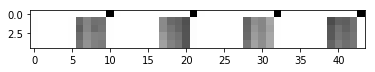

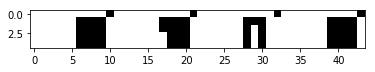

('Iteration', 3000, 'Train loss:', 0.16040424927080391)
Test loss:  0.193053658604
Input


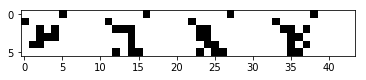

Target


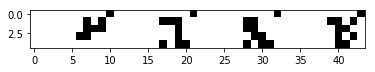

Predicted


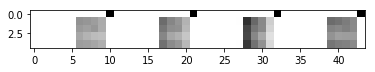

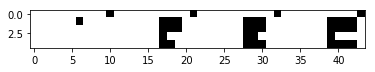

('Iteration', 4000, 'Train loss:', 0.17752186217965138)
Test loss:  0.182103858928
Input


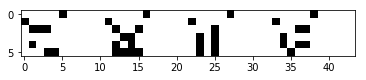

Target


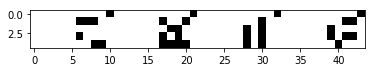

Predicted


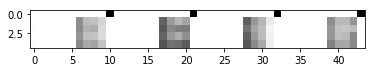

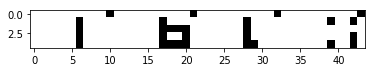

('Iteration', 5000, 'Train loss:', 0.14417570901875074)
Test loss:  0.176557909388
Input


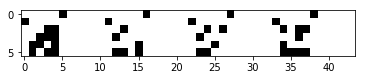

Target


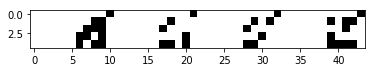

Predicted


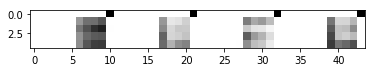

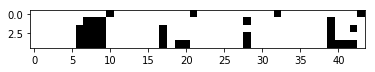

('Iteration', 6000, 'Train loss:', 0.11092541794146663)
Test loss:  0.130007251907
Input


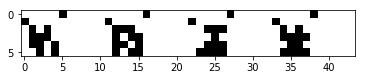

Target


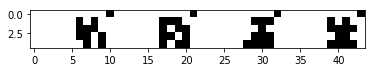

Predicted


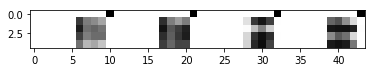

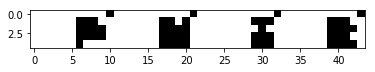

('Iteration', 7000, 'Train loss:', 0.14557318135991709)
Test loss:  0.129975113026
Input


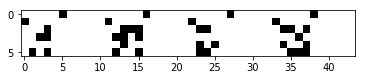

Target


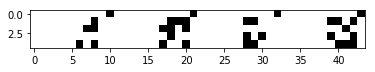

Predicted


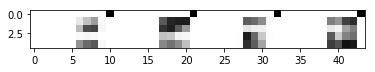

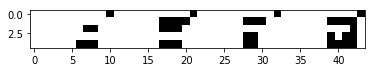

('Iteration', 8000, 'Train loss:', 0.10052498574417264)
Test loss:  0.143378897624
Input


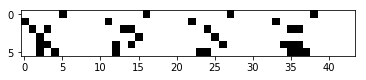

Target


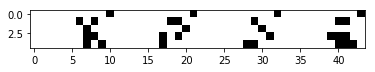

Predicted


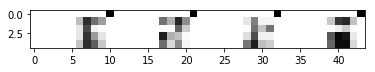

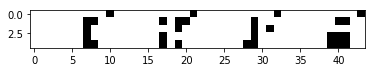

('Iteration', 9000, 'Train loss:', 0.11996405182031056)
Test loss:  0.138249116915
Input


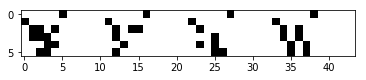

Target


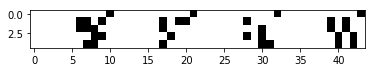

Predicted


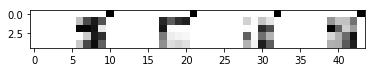

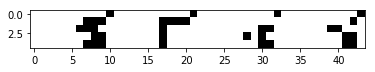

('Iteration', 10000, 'Train loss:', 0.10403950256251225)
Test loss:  0.0979447278123
Input


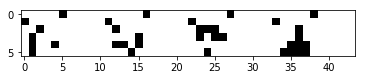

Target


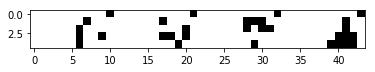

Predicted


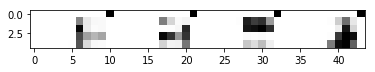

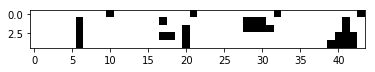

('Iteration', 11000, 'Train loss:', 0.10559546127582657)
Test loss:  0.0856181423907
Input


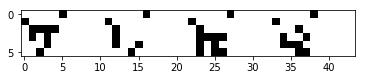

Target


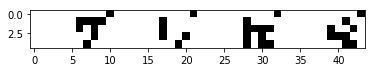

Predicted


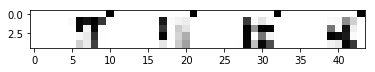

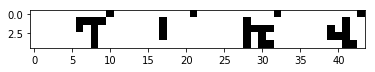

('Iteration', 12000, 'Train loss:', 0.069732620396053643)
Test loss:  0.0737735605445
Input


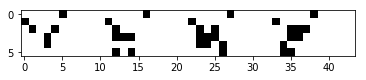

Target


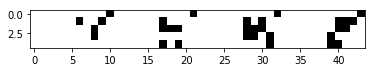

Predicted


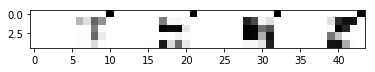

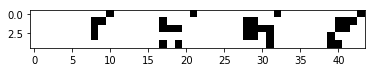

('Iteration', 13000, 'Train loss:', 0.066272415557329975)
Test loss:  0.0815225803656
Input


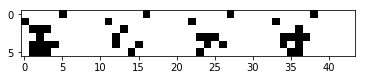

Target


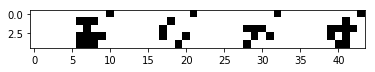

Predicted


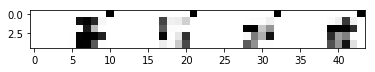

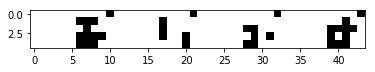

('Iteration', 14000, 'Train loss:', 0.062694513964887705)
Test loss:  0.0755212599197
Input


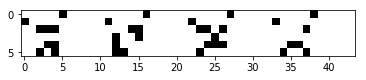

Target


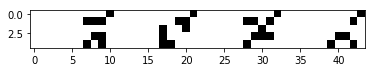

Predicted


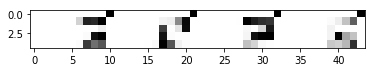

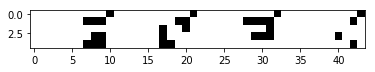

('Iteration', 15000, 'Train loss:', 0.050168430672524134)
Test loss:  0.0389464332453
Input


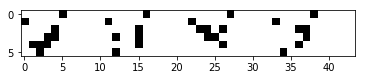

Target


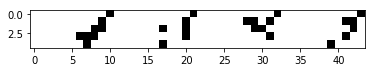

Predicted


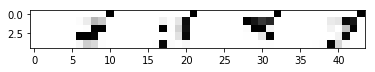

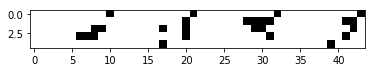

('Iteration', 16000, 'Train loss:', 0.086057955441826595)
Test loss:  0.0244324111134
Input


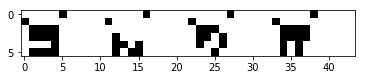

Target


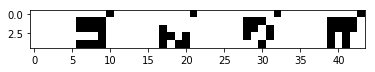

Predicted


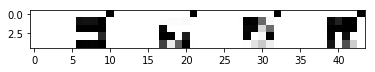

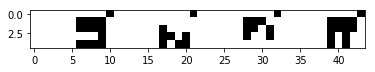

('Iteration', 17000, 'Train loss:', 0.053465910442757739)
Test loss:  0.0161677333003
Input


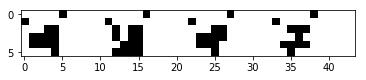

Target


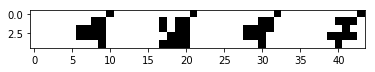

Predicted


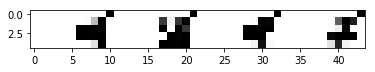

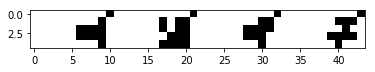

('Iteration', 18000, 'Train loss:', 0.022383144886887821)
Test loss:  0.0151489134439
Input


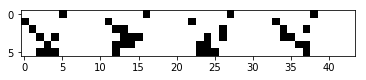

Target


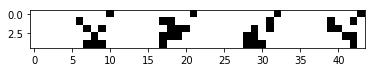

Predicted


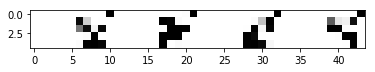

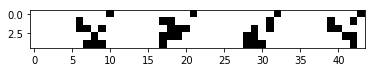

In [ ]:
## Testing recurrent DNC

def loss_fn(pred, target, mask):
    pred = sigmoid(pred)
    one = np.ones_like(pred)
    epsilon = 1.e-20 # to prevent log(0)
    a = target * np.log(pred + epsilon)
    b = (one - target) * np.log(one - pred + epsilon)
    return np.mean(- (a + b) * mask)

seq_len, seq_wid = 4, 4

# dnc = DNCFF(input_size=seq_wid+2, output_size=seq_wid+1, hidden_size=32, R=2, N=64, W=4)
dnc = DNC(input_size=seq_wid+2, output_size=seq_wid+1, hidden_size=32, R=2, N=64, W=8)
dnc_params = dnc._init_params()

def print_training_prediction(params, iters):
    
    inputs, targets, mask = long_copy(seq_len, seq_wid)
    result = []
    dnc = DNC(input_size=seq_wid+2, output_size=seq_wid+1, hidden_size=32, R=2, N=64, W=8)
    for t in range(inputs.shape[0]):
        out = dnc.step_forward(params, inputs[np.newaxis, t])
        result.append(out)
    result = np.concatenate(result, axis=0)
    loss = loss_fn(result, targets, mask)
    print "Test loss: ", loss
    print "Input"
    display(inputs.T)
    print "Target"
    display(targets.T)
    print "Predicted"
    display((sigmoid(result)).T)
    display(np.around((sigmoid(result) * mask), decimals=0).astype('int').T)
    
    # Saving Model Check Points
    save_pickle(params, './copy_suppress/Iter_%d_Loss_%.6f.pkl' % (iters, loss))

    
def training_loss(params, iters):
    inputs, targets, mask = long_copy(seq_len, seq_wid)
    result = []
    dnc = DNC(input_size=seq_wid+2, output_size=seq_wid+1, hidden_size=32, R=2, N=64, W=8)
    for t in range(inputs.shape[0]):
        out = dnc.step_forward(params, inputs[np.newaxis, t])
        result.append(out)
    result = np.concatenate(result, axis=0)
    return loss_fn(result, targets, mask) 

def callback(weights, iters, gradient):
    if iters % 1000 == 0:
        print("Iteration", iters, "Train loss:", training_loss(weights, 0))
        print_training_prediction(weights, iters)

# Build gradient of loss function using autograd.
training_loss_grad = grad(training_loss)

print("Training DNC...")
# trained_params = adam(training_loss_grad, dnc_params, step_size=0.001,
#                       num_iters=1000000, callback=callback)
trained_params = rmsprop(training_loss_grad, dnc_params, step_size=0.001,
                      num_iters=1000000, callback=callback)